In [1]:
import cv2
import math
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from IPython.display import display, HTML

%matplotlib inline

In [2]:
image = cv2.imread("/home/cvk/mmocr/demo/img/demo28.png")
result = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
# Detect horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=4)
cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

yLines = []
for c in cnts:
    yLines.append(c[0][0][1])

vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,10))
detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=4)
cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

xLines=[]
for c in cnts:
    xLines.append(c[0][0][0])
    
cv2.imwrite("result.png", result)

xLines.sort()
yLines.sort()

In [3]:
cells = []

for y in range(len(yLines) - 1):
    tmp = []
    for x in range(len(xLines) - 1):
        tmp.append([xLines[x], yLines[y], xLines[x+1], yLines[y+1]])
    cells += tmp

# Computing rows bounding boxes
rows = []
for y in range(len(yLines) - 1):
    rows.append([xLines[0], yLines[y], xLines[-1], yLines[y+1]])

numberOfRows = len(rows)
numberOfColumns = len(yLines)

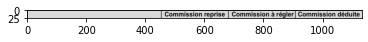

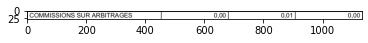

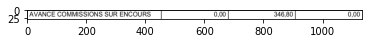

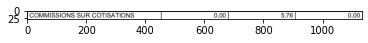

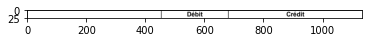

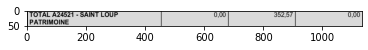

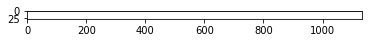

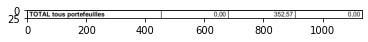

8


In [17]:
for i in rows:
    plt.imshow(image[i[1]:i[3], i[0]:i[2]])
    plt.show()
    
print(len(rows))

In [21]:
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
data = pytesseract.image_to_data(rgb, output_type=Output.DICT)


In [22]:
# Create the data List

results = []

for idx, i in enumerate(data['text']):
    if not i == '' and not i == '|' and not i == ' ':
        results.append({
            'x': (2 * data['left'][idx] + data['width'][idx]) // 2,
            'y': (2 * data['top'][idx] + data['height'][idx]) // 2,
            'xMin': data['left'][idx],
            'yMin': data['top'][idx],
            'xMax': data['left'][idx] + data['width'][idx],
            'yMax': data['top'][idx] + data['height'][idx],
            'text': i
        })

In [23]:
def countOverlappingClusters(clusters, classification, ranges):
    rv = 0
    for cdx, c in enumerate(clusters):
        for rdx, r in enumerate(ranges):
            if c[0] >= r[0] and c[0] <= r[1] and not classification[rdx] == cdx:
                rv += 1
    return rv

def findAB(x1, y1, x2, y2):
    a = (y2-y1) / (x2 - x1)
    b = y1 - ( x1 * (y2-y1) / (x2 - x1))
    return (a, b)

def findSpot(ax, ay):
    rv = []
    for n in range (1, len(ax)-1):
        (a1, b1) = findAB(ax[0], ay[0], ax[n], ay[n]) 
        (a2, b2) = findAB(ax[n], ay[n], ax[-1], ay[-1])
        total = 0
        for idx in range(0, n):
            total += (a1*ax[idx] + b1) - ay[idx]
        for idx in range(n, len(ay)):
            total += (a2*ax[idx] + b2) - ay[idx]
        rv.append((n, total))
        
    rv.sort(key=lambda x: x[1])
    
    return ax[rv[0][0]]
            

In [24]:
X = np.array([[elem['y']] for elem in results])
ranges = [(a['yMin'], a['yMax']) for a in results]

ax = []
ay = []

for n in range(2, len(results) // numberOfColumns):
    
    kmeans = KMeans(n_clusters=n, random_state=42).fit(X)
    clusters = kmeans.cluster_centers_
    classificaction = kmeans.labels_
    
    ax.append(n)
    ay.append(countOverlappingClusters(clusters, classificaction, ranges))

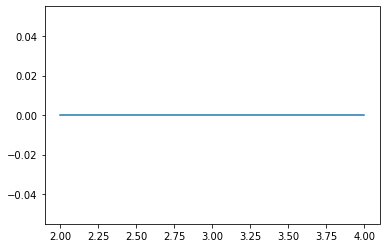

In [25]:
plt.plot(ax, ay, label='overlapping count')

In [26]:
clusterNumber = findSpot(ax, ay)

In [27]:
kmeans = KMeans(n_clusters=clusterNumber, random_state=42).fit(X)

In [28]:
for idx, i  in enumerate(results):
    results[idx]['class'] = kmeans.labels_[idx]
    for k in range(len(yLines)-1):
        if results[idx]['y'] >= yLines[k] and results[idx]['y'] <= yLines[k+1]:
            results[idx]['yIndex'] = k
            break
            
    for k in range(len(xLines)-1):
        if results[idx]['x'] >= xLines[k] and results[idx]['x'] <= xLines[k+1]:
            results[idx]['xIndex'] = k
            break
            

In [29]:
rowMapping = {i : [] for i in range(numberOfRows)}
a = [(i[0], idx) for idx, i in enumerate(kmeans.cluster_centers_)]
a.sort(key=lambda x:x[0])
for idx in range(len(yLines) - 1):
    for k in a:
        if k[0] >= yLines[idx] and k[0] <= yLines[idx+1]:
            rowMapping[idx].append(k[1])
rowMapping

{0: [2], 1: [], 2: [], 3: [0], 4: [], 5: [1], 6: [], 7: []}

In [30]:
# Generate the empty result array
array = [['' for _ in range(numberOfColumns)] for _ in range(numberOfRows)]
for i in array:
    print(i)

['', '', '', '', '', '', '', '', '']
['', '', '', '', '', '', '', '', '']
['', '', '', '', '', '', '', '', '']
['', '', '', '', '', '', '', '', '']
['', '', '', '', '', '', '', '', '']
['', '', '', '', '', '', '', '', '']
['', '', '', '', '', '', '', '', '']
['', '', '', '', '', '', '', '', '']


In [31]:
# Filling the result array
for idx, i in enumerate(array):
    for jdx, j in enumerate(i):
        for rdx, r in enumerate(rowMapping[idx]):
            for kdx, k in enumerate(results):
                if k['class'] == r and 'xIndex' in k and k['xIndex'] == jdx:
                    array[idx][jdx] += f"{k['text']} "
            if not rdx == len(rowMapping[idx]) - 1:
                array[idx][jdx] += "\n"

In [32]:
array

[['A24521 COMMISSIONS SUR ARBITRAGES ',
  '- SAINT LOUP Commission reprise 0,00 ',
  'PATRIMOINE Commission a régler| 0,01 ',
  '',
  'Commission déduite 0,00 ',
  '',
  '',
  '',
  ''],
 ['', '', '', '', '', '', '', '', ''],
 ['', '', '', '', '', '', '', '', ''],
 ['AVANCE COMMISSIONS SUR ENCOURS COMMISSIONS SUR COTISATIONS ',
  '0,00 0,00 Débit ',
  '346,80 5,76 ',
  '',
  '0,00 0,00 Crédit ',
  '',
  '',
  '',
  ''],
 ['', '', '', '', '', '', '', '', ''],
 ['TOTAL A24521 - SAINT LOUP PATRIMOINE TOTAL tous portefeuilles ',
  '0,00 0,00 ',
  '352,57 352,57 ',
  '',
  '0,00 0,00 ',
  '',
  '',
  '',
  ''],
 ['', '', '', '', '', '', '', '', ''],
 ['', '', '', '', '', '', '', '', '']]

In [33]:
resultDf = pd.DataFrame(np.array(array))
resultDf.to_csv("result.csv", index=False, sep=',', encoding='utf-8')